In [1]:
import dateutil
import datetime as dt
import time
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from scipy import signal
import datetime as dt
import pylab
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
df_set = pd.read_excel('TR_Sets.xlsx')

In [3]:
df = pd.read_csv('filtered_joined_df_.csv')

In [4]:
customers_names = pd.read_csv('sellin_customers_1.csv')
customers_names = customers_names.set_index('CUSTOMER_ID')
customers_names = customers_names[['NCUS']]
df = df.join(customers_names, on='CUSTOMER_ID')
df = df.loc[df['Q_BIL_GROSAL'] > 0]

In [5]:
df.shape

(11791993, 37)

In [6]:
df2 = df.groupby(['LFORSUBARE','CITE']).aggregate({'Q_BIL_GROSAL':'count'})

In [7]:
cites_sup3 = set(df2.loc[df2['Q_BIL_GROSAL'] > 3].index.get_level_values(1))

In [8]:
cites_sup3

{'G017967',
 'G013821',
 'G017668',
 'G043009',
 'G002256',
 'G061469',
 'G002456',
 'G011809',
 'G041348',
 'G002502',
 'G002648',
 'G042408',
 'G002503',
 'G002500',
 'G017229',
 'G010435',
 'KRIMK0323B',
 'G017382',
 'G010445',
 'G002450',
 'G017209',
 'G017868',
 'G013769',
 'KRIMK0289B',
 'G011829',
 'G002810',
 'G017661',
 'G002467',
 'G017467',
 'G011389',
 'G013171',
 'G017427',
 'G002754',
 'G064139',
 'G041170',
 'G002196',
 'G002761',
 'G013410',
 'G013442',
 'G061214',
 'G002793',
 'G002330',
 'G002660',
 'G060945',
 'G010539',
 'G017195',
 'G002350',
 'G002630',
 'G061462',
 'G030251',
 'G060259',
 'G030269',
 'G041157',
 'G017787',
 'G017616',
 'G061148',
 'G011750',
 'G061100',
 'G042605',
 'G041392',
 'G002588',
 'G013495',
 'G002297',
 'G041888',
 'G061160',
 'G002582',
 'G041273',
 'G041797',
 'G013159',
 'G002251',
 'G061154',
 'G061122',
 'G042513',
 'G042847',
 'G013838',
 'G011536',
 'G011598',
 'G030271',
 'G041321',
 'G002600',
 'G011473',
 'G060966',
 'G017160'

In [9]:
df = df.loc[df['CITE'].isin(cites_sup3)]

In [10]:
df.shape

(11790269, 37)

In [11]:
df_grouped_cite = df.groupby(['LFORSUBARE', 'CITE','Year','Month']).aggregate({'Year':'mean','Month':'mean','Q_BIL_GROSAL':'sum'})
df_grouped_cite['Date'] = pd.to_datetime(df_grouped_cite['Year'].astype(str) + '-'+df_grouped_cite['Month'].astype(str) +'-01')
df_grouped_cite = df_grouped_cite.drop(columns =['Year','Month'])
df_grouped_cite.loc['TR Asia']

Q_BIL_GROSAL       Date
CITE    Year Month                         
G002859 2019 11             2150 2019-11-01
             12             2350 2019-12-01
G010034 2016 1                 5 2016-01-01
             2                 6 2016-02-01
             6                 1 2016-06-01
...                          ...        ...
G064203 2018 2                 2 2018-02-01
             3                 3 2018-03-01
             7                 4 2018-07-01
        2019 7                 4 2019-07-01
             10                5 2019-10-01

[18064 rows x 2 columns]

In [12]:
df_set_synt = df_set.loc[df_set['TyAr'] == 'ZPF'][['Article', 'Composant']].set_index('Composant')

In [13]:
len(set(df_set_synt.index))

272

In [68]:
country = 'TR Asia'

cites_TR_Asia = set(df_grouped_cite.loc[country].index.get_level_values(0))
i = 0

lags = [-2,-1,0,1,2]
columns_names = ['Composant','Set Parent'] + ['Correlation Lag ' + str(lag) for lag in lags]
df_all_correl = pd.DataFrame(columns = columns_names)

for cite in set(df_set_synt.index):
    
    df_for_correl = pd.DataFrame()
    
    if cite in cites_TR_Asia:
        i= i+1
        #### Plot 
        fig = go.Figure()
        fig.update_layout(height=500, width=700)
        fig.update_layout(
        yaxis_title='Sales_Quantity',
        xaxis_title="Date")

        df_cite = df_grouped_cite.loc[(country,cite)].set_index('Date')
        fig.add_trace(go.Scatter(x=df_cite.index, y=df_cite['Q_BIL_GROSAL'], name = 'Composant ' + cite ))
        
        df_for_correl = df_cite
        
        cite_set =   list(df_set_synt.loc[cite]['Article'])

                
        flag = False
        for cite_set_i in cite_set:
                if cite_set_i in cites_TR_Asia:
                    
                    df_cite_set = df_grouped_cite.loc[(country,cite_set_i)].set_index('Date')

                    df_cite_set=df_cite_set.rename(columns = {'Q_BIL_GROSAL': cite_set_i})
                    
                    if df_cite_set.shape[0] > 6:
                        correls = []
                        df_for_correl = pd.concat([df_for_correl,df_cite_set],axis = 1)
                        df_cite_shifted = pd.DataFrame()
                        for lag in lags:
                            df_for_correl[cite_set_i + '_shifted_'+ str(lag)] = df_for_correl[cite_set_i].shift(lag)
                            correl = df_for_correl['Q_BIL_GROSAL'].corr(df_for_correl[cite_set_i + '_shifted_'+ str(lag)],'pearson')
                            correls.append(correl)
                            if abs(correl) > 0.7:
                                flag = True
                                fig.add_trace(go.Scatter(x=df_for_correl.index, y=df_for_correl[cite_set_i + '_shifted_'+ str(lag)]
                                                         , name = 'Set ' + cite_set_i + '_shifted_'+ str(lag) + '  with R2 : ' + str(round(correl,2))))
                                
                                
                        df_all_correl = df_all_correl.append(pd.DataFrame([[cite, cite_set_i] + correls],
                                                                  columns = columns_names))
        if flag:
            fig.show()
                

In [69]:
df_all_correl = df_all_correl.set_index(['Composant','Set Parent'])

In [74]:

fig = go.Figure(data=go.Heatmap( 
    x=[-2,-1,0,1,2],
                   z=df_all_correl))
fig.show()

(array([ 2.,  0.,  5., 13.,  3.,  9., 11.,  8.,  3.,  8.]),
 array([-0.68097154, -0.51762038, -0.35426923, -0.19091807, -0.02756692,
         0.13578424,  0.2991354 ,  0.46248655,  0.62583771,  0.78918886,
         0.95254002]),
 <a list of 10 Patch objects>)

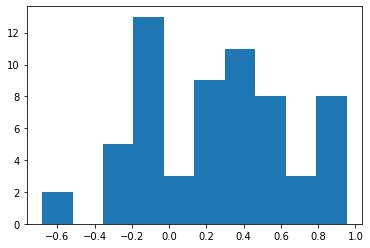

In [24]:
plt.hist(df_all_correl['Correlation'])

In [66]:
df_all_correl['Max Correl'] = df_all_correl.max(axis=1)

(array([ 1.,  0.,  2.,  1.,  4., 11., 10., 13., 10., 10.]),
 array([-0.39810103, -0.26261463, -0.12712822,  0.00835818,  0.14384458,
         0.27933099,  0.41481739,  0.5503038 ,  0.6857902 ,  0.82127661,
         0.95676301]),
 <a list of 10 Patch objects>)

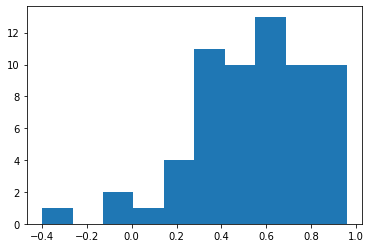

In [67]:
plt.hist(df_all_correl['Max Correl'])